# 텍스트 요약(Text Summarization)
**텍스트 요약은 크게 추출적 요약(Extractive Summarization)**과 **추상적 요약(Abstractive Summarization)**의 두 가지 접근으로 나누어볼 수 있습니다.  

- 추출적 요약: 문장을 추출
- 추상적 요약: 새로운 문장을 생성

http://www.zdnet.co.kr/view/?no=20160905114833&from=Mobile

1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

## 아마존 리뷰 줄이기 (추상적 요약)
seq2seq를 통해서 추상적 요약을 진행
### 데이터 준비
#### 아마존 리뷰 데이터셋  
https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip  

NLTK(Natural Language Toolkit)의 불용어(stopwords)를 사용합니다. 

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
# 데이터에는 568,454개의 샘플이 있지만 10만 개의 샘플만 사용
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# 데이터 중 Summary 열과 Text 열만 사용한다. 
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
11149,I have three children and seven nieces/nephews...,Lucy's Cookies A++
88163,I'm a busy mom with two jobs and a 6 month old...,HappyBaby is my go-to
37660,"Well, I have never seen them at our local Wal ...",Apparently you can get these at Wal Mart too???
92350,This is not a good coffee. The coffee taste o...,"No flavor, taste like old coffee"
85211,This is the best freeze dried coffee I have ev...,lori c
34762,We received some as a gift from friends in Tex...,Excellent product
52795,Fantastic taste with low calories (70 cals for...,Delicious!
86142,I have a one and a half year old shiba. He lov...,Dog loves it
12830,These are very tasty and they will crunch with...,One of the Best!
97254,We have searched and searched for a food that ...,Wonderful Dog Food


Text 열의 내용을 요약한 것이 Summary 열입니다.  
인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킵니다.

### 데이터 전처리
#### 데이터 정리하기
##### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
# 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있어요.  

하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야겠죠.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# Null 값이 있는지 확인
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# Null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


##### 텍스트 정규화와 불용어 제거
단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있습니다.  

예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법입니다.  

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)** 라고 합니다.  

정규화 사전 출처  
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# NLTK에서 제공하는 불용어 리스트
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

이를 사용하여 불용어를 제거하고 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리합니다.  

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'# 전처리 전, 후의 결과를 확인하기 위해서 임의의 변수를 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the 

print(preprocess_sentence(temp_text))
# summary의 경우 불용어를 제거하지 않습니다.
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
# 이 코드는 시간이 오래 걸리므로 멀티프로세싱 코드로 실행하기 위해 주석 처리했습니다.
'''
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print(clean_text[:5])


clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print(clean_summary[:5])
'''

"\nclean_text = []\n# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. \nfor s in data['Text']:\n    clean_text.append(preprocess_sentence(s))\n\n# 전처리 후 출력\nprint(clean_text[:5])\n\n\nclean_summary = []\n# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. \nfor s in data['Summary']:\n    clean_summary.append(preprocess_sentence(s, False))\n\nprint(clean_summary[:5])\n"

In [14]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

# Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False
clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

229.78806948661804  seconds
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch'
 ...
 'favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack'
 'like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much'
 'love noodle twice week amazing thing feel wel

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


5.11279034614563  seconds
['good quality dog food' 'not as advertised' 'delight says it all' ...
 'great ramen' 'spicy'
 'this spicy noodle cures my cold upset stomach and headache every time']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋습니다.  

정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# Null 값이 생겼는지 확인
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미입니다.  

In [17]:
# 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


#### 데이터 나누기

##### 샘플의 최대 길이 정하기
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정합니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


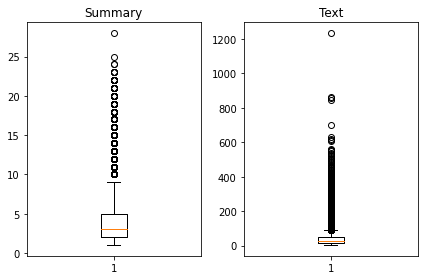

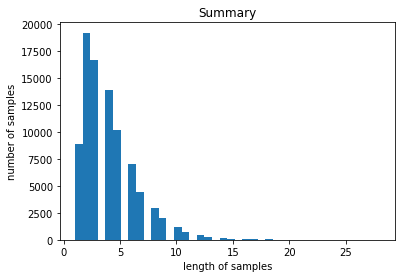

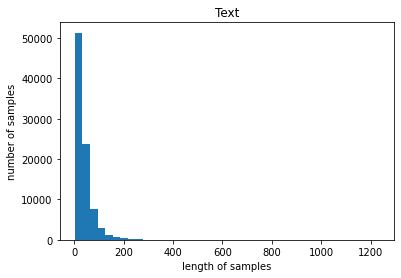

In [18]:
# Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 적절한 최대 길이를 임의로 지정
text_max_len = 50
summary_max_len = 8

In [20]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [22]:
# 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하겠습니다. 
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


##### 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춥니다. 
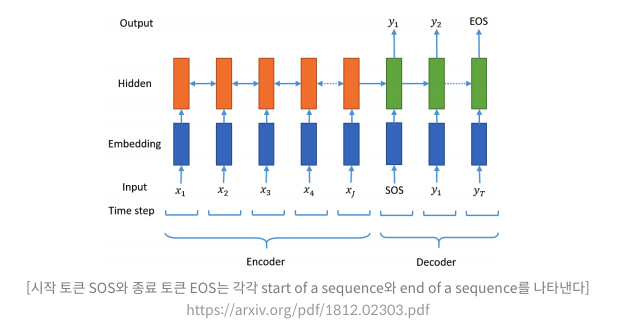

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 합니다.  

여기서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가하겠습니다.  

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
# 인코더의 입력, 디코더의 입력과 레이블을 각가 다시 Numpy 타입으로 저장해줍니다.
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [25]:
# 훈련 데이터와 테스트 데이터를 분리 (직접 코딩을 통해서 분리하는 방법)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22288 46638 26131 ... 63574 28095  6841]


In [26]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됩니다. 
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [28]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


#### 정수 인코딩
##### 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 합니다.  각 단어에 고유한 정수를 맵핑하는 작업이 필요합니다. 

이 과정을 **단어 집합(vocabulary)**을 만든다고 표현합니다. 

In [29]:
# Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합 생성
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# 생성된 단어 집합은 src_tokenizer.word_index에 저장

이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 합니다.

In [30]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31959
등장 빈도가 6번 이하인 희귀 단어의 수: 23713
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8246
단어 집합에서 희귀 단어의 비율: 74.19819143277324
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.377434613353772


등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지합니다.  

등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.  



In [31]:
# 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력(8,000이 넘는 숫자들은 존재하지 않음)
print(encoder_input_train[:3])

[[332, 11, 18, 822, 782, 1870, 77, 252, 77, 252, 1, 1668, 19, 2453, 19, 2453, 43], [3, 15, 142, 14, 782, 370, 143, 611, 65, 4273, 3827, 33, 145, 119, 42, 374, 1175, 210, 2575, 599, 1236, 44, 3065], [101, 179, 47, 50, 1674, 277, 158, 52, 935, 3399, 64, 2199, 47, 50, 362, 315, 4372, 47, 50, 29, 277, 73, 271, 136, 277, 5909, 362, 315, 277, 5103, 225, 4, 604, 2501, 234, 847, 29, 865, 55, 133, 239, 4, 33, 5277, 29, 201, 2145, 2472]]


In [33]:
# Summary 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10494
등장 빈도가 5번 이하인 희귀 단어의 수: 8120
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2374
단어 집합에서 희귀 단어의 비율: 77.37754907566229
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.924984928085436


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지합니다.  

아까 했던 것과 동일하게 이 단어들은 모두 제거합니다.  
어림잡아 2,000을 단어 집합의 크기로 제한 하겠습니다.

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 182, 14, 1157, 5, 1062], [1, 3, 101, 10, 28, 116], [1, 140, 1098, 71, 1158, 20, 15, 37], [1, 3, 125], [1, 1649, 44]]
target
decoder  [[182, 14, 1157, 5, 1062, 2], [3, 101, 10, 28, 116, 2], [140, 1098, 71, 1158, 20, 15, 37, 2], [3, 125, 2], [1649, 44, 2]]


##### 점검사항
다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있습니다.  

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있습니다.  

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와보겠습니다.  

여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요.  

그래서 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해서 모두 삭제하겠습니다.

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1276
삭제할 테스트 데이터의 개수 : 338
훈련 데이터의 개수 : 51379
훈련 레이블의 개수 : 51379
테스트 데이터의 개수 : 12825
테스트 레이블의 개수 : 12825


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


##### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해야 합니다.  

In [37]:
# 아까 정해두었던 최대 길이로 패딩, 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줍니다.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 모델 설계하기
함수형 API를 이용해서 인코더를 설계

hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터로 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수입니다.  
(무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아님)

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높입니다.  
hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘리는 것입니다.  

#### 인코더

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더
디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하지만  
LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 합니다.

In [39]:
# 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보냅니다. 

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 합니다.  

그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있습니다.  


##### 어텐션 메커니즘
디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법  

In [41]:
# 깃허브에 공개돼 있는 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [42]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 145s 665ms/step - loss: 3.1239 - val_loss: 2.4286
Epoch 2/50
201/201 [==============================] - 133s 660ms/step - loss: 2.4272 - val_loss: 2.3171
Epoch 3/50
201/201 [==============================] - 132s 656ms/step - loss: 2.2855 - val_loss: 2.1739
Epoch 4/50
201/201 [==============================] - 133s 661ms/step - loss: 2.1267 - val_loss: 2.0792
Epoch 5/50
201/201 [==============================] - 132s 656ms/step - loss: 2.0473 - val_loss: 2.0331
Epoch 6/50
201/201 [==============================] - 133s 660ms/step - loss: 1.9715 - val_loss: 1.9762
Epoch 7/50
201/201 [==============================] - 132s 657ms/step - loss: 1.9132 - val_loss: 1.9377
Epoch 8/50
201/201 [==============================] - 132s 658ms/step - loss: 1.8696 - val_loss: 1.9178
Epoch 9/50
201/201 [==============================] - 132s 659ms/step - loss: 1.8321 - val_loss: 1.8983
Epoch 10/50
201/201 [==============================] - 133s 660m

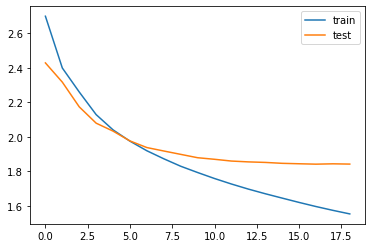

In [44]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.



In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 합니다.  

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했으나  

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다.  

이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기
정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만드는데  
Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고  
Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : love flavored tea blackberry pomegranate love tea mix thinking must green tea flavor black tea saying like lipton tea honey love 
실제 요약 : green tea is different 
예측 요약 :  great tea


원문 : chocolate everything expired gift brother eat 
실제 요약 : expired 
예측 요약 :  stale


원문 : best coffee ever smooth full flavor get little bitter much coffee 
실제 요약 : fantastic 
예측 요약 :  great coffee


원문 : syrup tastes like chemical sweetener unpleasant bad aftertaste stay away hershey product expensive price worth 
실제 요약 : do not waste your money 
예측 요약 :  tastes like plastic


원문 : wonderful gluten free brownies brought social gatherings people raved knowing gluten free tried brands brownie mix compare 
실제 요약 : yummy 
예측 요약 :  best brownies ever


원문 : making great also water great upset tummy grandsons tummy 
실제 요약 : many uses 
예측 요약 :  great product


원문 : enjoyed butter chicken many times thought would give curry try big mistake following recipe dish inedible salty really hoping curry pack could 

예측 요약 :  best honey ever


원문 : hard find aluminum free baking powder local store small packages shipping makes price bit high convienient since buy bulk 
실제 요약 : baking powder 
예측 요약 :  great product


원문 : dog picky eater would giving meals three weeks vet said get something nutritionally balanced towards got one looked like good ingredients reasonable price normally dog eat dry food nearly two days wet food pleasant surprise started eating food within hours couple weeks seem tired 
실제 요약 : the dog seems to love it 
예측 요약 :  my dog loves them


원문 : amazingly yummy good balances chocolate peanut butter chewy crunchy bad maybe even sort good great job 
실제 요약 : yummy 
예측 요약 :  delicious


원문 : bought several revolution flavored teas white pomegranate sweet ginger peach loved however tea good pear flavor even subtle one bit bitter really like plain white tea like fine expect pear taste 
실제 요약 : no pear taste 
예측 요약 :  great tea


원문 : highly addictive cant eat one sweet either thats lov

일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다.

## 추출적 요약 해보기
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습이 가능합니다.  

영화 매트릭스 시놉시스를 요약해보겠습니다.

### 데이터 다운로드

In [51]:
import requests
from summa.summarizer import summarize

In [52]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [53]:
# 아주 긴 문자열이기 때문에 일부만 출력
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들
- text(str): 요약할 테스트
- ratio(float, optional): 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words(int ot None, optional): 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다. 
- split(bool, optional): True면 문장 list / False는 join된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다.  

In [54]:
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄임
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [55]:
# 리스트로 출력 결과 받기
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [56]:
# 단어 50개만 선택하도록 요약문 크기 조절
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
